In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math

In [4]:
symbol = input("enter symbol here : ")

##### Fetch Live stock data 

In [5]:
import yfinance as yf

print(f"Fetching data for '{symbol}' using yfinance...")

try:
    # 2. Create a Ticker object
    sym_data = yf.Ticker(symbol)

    # 3. Fetch historical market data (last 60 days with 10-minute intervals)
    data = sym_data.history(period="2y", interval="1d")

    data = data.reset_index()  # Reset index to make 'Datetime' a column
    # The column name after reset_index depends on the yfinance version,
    # it could be 'Datetime' or 'index'. We'll handle 'Datetime'.
    # if "Datetime" in data.columns:
    #     # Format the 'Datetime' column to 'YYYY-MM-DD HH:MM'
    #     data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")
    # elif "index" in data.columns:
    #     data = data.rename(columns={"index": "Datetime"})
    #     data["Datetime"] = data["Datetime"].dt.strftime("%Y-%m-%d %H:%M")

    # We now have the 'Datetime' column to include.
    data = data[["Date", "Open", "High", "Low", "Close", "Volume"]]

    # 7. Display the final data
    print("\nHere are the last 5 data points with the formatted Datetime column:")
    print(data.tail())

except Exception as e:
    print(f"\nAn error occurred: {e}")

Fetching data for 'INDUSTOWER.NS' using yfinance...

Here are the last 5 data points with the formatted Datetime column:
                         Date        Open        High         Low       Close  \
488 2025-08-19 00:00:00+05:30  339.700012  342.500000  335.250000  339.950012   
489 2025-08-20 00:00:00+05:30  341.850006  355.100006  341.299988  349.100006   
490 2025-08-21 00:00:00+05:30  350.049988  353.450012  346.600006  348.049988   
491 2025-08-22 00:00:00+05:30  352.500000  359.799988  348.799988  353.549988   
492 2025-08-25 00:00:00+05:30  356.750000  357.700012  351.299988  354.750000   

       Volume  
488   3615727  
489   7536509  
490   2900166  
491  16977389  
492   4414756  


##### Neccesary Data pre-processing steps 

In [6]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T)

summary statistics  
         count          mean           std         min           25%  \
Open    493.0  3.215714e+02  8.218159e+01  164.300003  2.348500e+02   
High    493.0  3.265253e+02  8.271756e+01  170.699997  2.478500e+02   
Low     493.0  3.158141e+02  8.104856e+01  164.300003  2.311000e+02   
Close   493.0  3.210324e+02  8.181721e+01  168.350006  2.382500e+02   
Volume  493.0  1.396482e+07  3.948386e+07    0.000000  5.386177e+06   

                 50%           75%           max  
Open    3.430000e+02  3.850000e+02  4.600000e+02  
High    3.486500e+02  3.910000e+02  4.603500e+02  
Low     3.385000e+02  3.800000e+02  4.452500e+02  
Close   3.427500e+02  3.846000e+02  4.585000e+02  
Volume  8.234519e+06  1.432741e+07  8.321550e+08  


##### Stock Price Visualization 

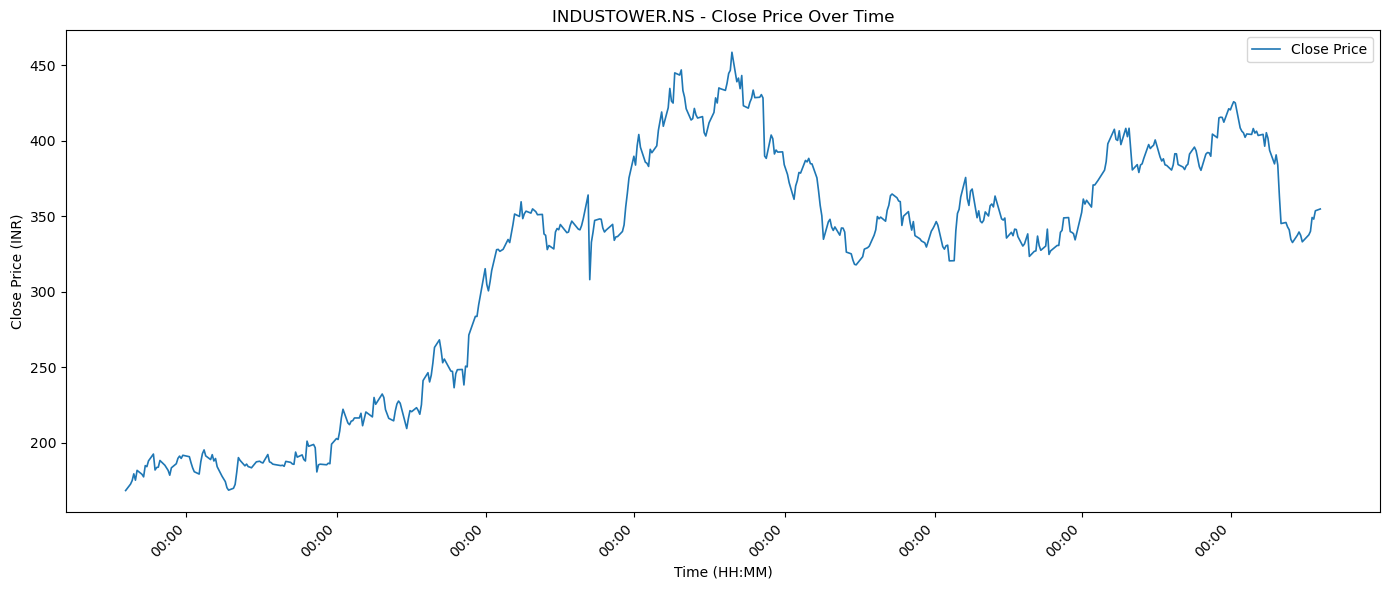

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 6))
plt.plot(data["Date"], data["Close"], label="Close Price", linewidth=1.2)

# Convert Datetime column back to datetime objects (if it's string-formatted earlier)
data["Date"] = pd.to_datetime(data["Date"])

# Format x-axis to show only HH:MM
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.xticks(rotation=45, ha="right")
plt.xlabel("Time (HH:MM)")
plt.ylabel("Close Price (INR)")
plt.title(f"{symbol} - Close Price Over Time")
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

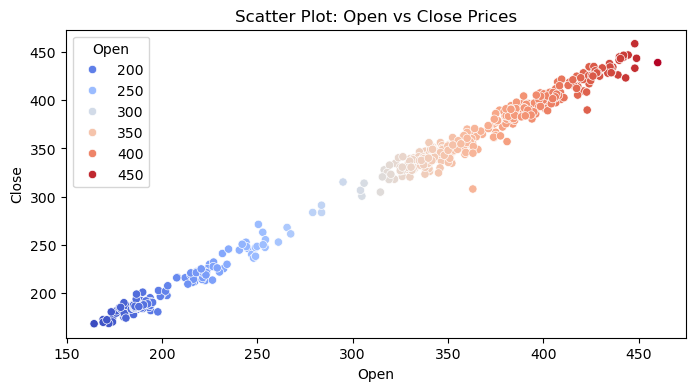

In [8]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

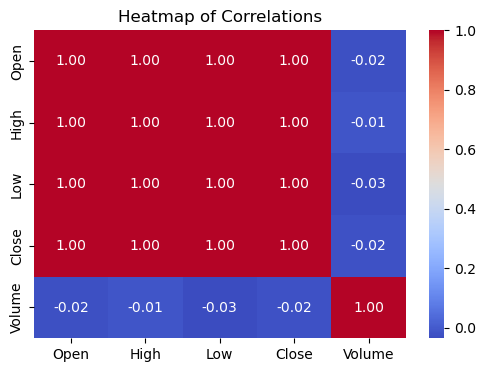

In [9]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [10]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))
print("Skewness (Volume):", skew(data['Volume']))

Skewness (Close): -0.5780868842856677
Skewness (Open): -0.5745226987591492
Skewness (High): -0.5879811078937145
Skewness (Low): -0.5604390520069722
Skewness (Volume): 18.33530426497513


#### Skewness Analysis 
- Market data or live time series data has very uneven skewness which is more common and expected due high volatility and other factors on markets

In [11]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

In [12]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [13]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
print(data.tail())

Overview of dataset after adding some features 


                         Date    Open    High     Low   Close    Volume  Trend
488 2025-08-19 00:00:00+05:30  339.70  342.50  335.25  339.95   3615727      1
489 2025-08-20 00:00:00+05:30  341.85  355.10  341.30  349.10   7536509      0
490 2025-08-21 00:00:00+05:30  350.05  353.45  346.60  348.05   2900166      1
491 2025-08-22 00:00:00+05:30  352.50  359.80  348.80  353.55  16977389      1
492 2025-08-25 00:00:00+05:30  356.75  357.70  351.30  354.75   4414756      0


### LSTM MODEL

##### 1️⃣ Preparing Your Data for LSTM
###### LSTMs expect 3D input: [samples, timesteps, features]
where
```
samples = number of training examples
timesteps = how many past days to look back
features = number of columns (Open, High, Low, Close, Volume)
```

Step 1: Apply transformations & scaling

In [14]:
# Scale all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open", "High", "Low", "Close", "Volume"]])

Step 2: Create sequences(timesteps)

In [15]:
def create_sequences(dataset, time_steps=90):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:(i + time_steps)])  # past 60 days
        y.append(dataset[i + time_steps, 0])   # 'Close' is 1st column here
    # Convert to numpy arrays for better performance with LSTM
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(scaled_data, time_steps)


Step 3: Train-test split (no shuffle)

In [16]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (346, 60, 5), (346,)
Testing data shape: (87, 60, 5), (87,)


Step 4: LSTM model (Keras - RNN variant) 

In [17]:
model = Sequential()
model.add(
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict close price

model.compile(optimizer="adam", loss="mean_squared_error")

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)

Epoch 1/50


c:\Devs\anaconda_navigator\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1461 - val_loss: 0.0038
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0162 - val_loss: 0.0093
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0110 - val_loss: 0.0043
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0077 - val_loss: 0.0056
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0095 - val_loss: 0.0035
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0069 - val_loss: 0.0034
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0077 - val_loss: 0.0029
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0055 - val_loss: 0.0028
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0070 - val_l

Model evaluation metrics

In [18]:
# Predictions
y_pred = model.predict(X_test)
# Inverse transform (to get actual prices back)
# y_test and y_pred are scaled — need to bring them back

# Create empty array for inverse scaling
y_test_inv = np.zeros((len(y_test), scaled_data.shape[1]))
y_pred_inv = np.zeros((len(y_pred), scaled_data.shape[1]))

# Put the close price predictions back in the correct column
y_test_inv[:, 3] = y_test
y_pred_inv[:, 3] = y_pred[:, 0]

# Inverse transform
y_test_inv = scaler.inverse_transform(y_test_inv)[:, 3]
y_pred_inv = scaler.inverse_transform(y_pred_inv)[:, 3]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [19]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 score:", r2)

RMSE: 13.136084855803606
MAE: 9.93809924113647
R2 score: 0.684439971759192


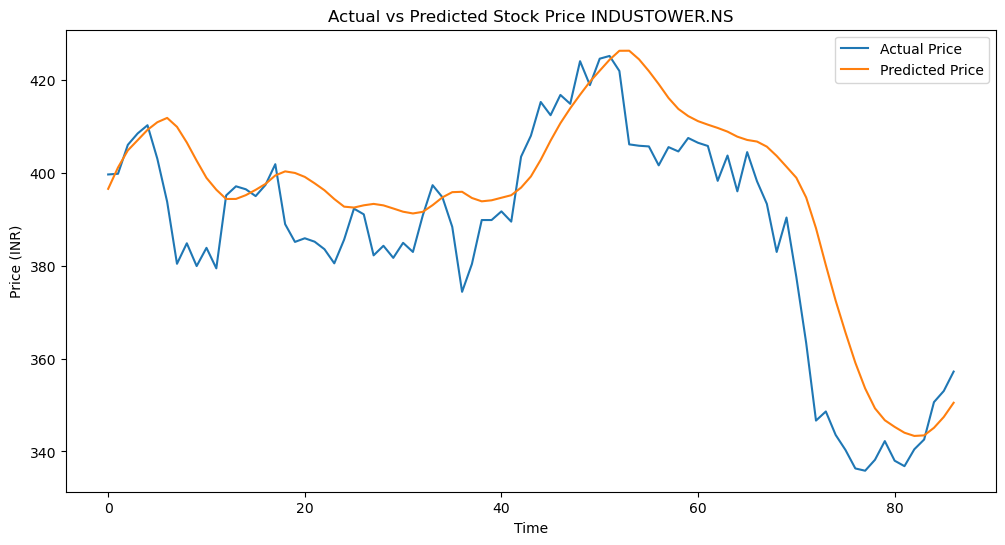

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(y_pred_inv, label="Predicted Price")
plt.title(f"Actual vs Predicted Stock Price {symbol}")
plt.xlabel("Time")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()

In [21]:
# --- 1. User Input for Forecast Period ---
try:
    forecast_minutes = int(input("Enter the number of minutes to forecast (e.g., 15, 30, 60): "))
    if forecast_minutes <= 0:
        raise ValueError
except ValueError:
    print("Invalid input. Please enter a positive number. Defaulting to 30 minutes.")
    forecast_minutes = 30

Invalid input. Please enter a positive number. Defaulting to 30 minutes.


In [22]:
# Since data interval is 5 minutes, calculate the number of steps to predict
future_steps = int(forecast_minutes / 5)
print(f"Forecasting for {forecast_minutes} minutes, which is {future_steps} 5-minute steps.")


# --- 2. Corrected Forecasting Logic ---
lookback = time_steps  # time_steps = 60 from your training cell

# Start with the last 'lookback' steps from your scaled dataset (with all 5 features)
last_sequence = scaled_data[-lookback:].copy()
forecast_predictions = []

for _ in range(future_steps):
    # Reshape the sequence to be a single sample with 5 features
    X_input = np.reshape(last_sequence, (1, lookback, 5))

    # Predict the next 5-minute interval's closing price (scaled)
    pred_scaled = model.predict(X_input)[0, 0]

    # Store the scaled prediction
    forecast_predictions.append(pred_scaled)

    # Create the next input row for the sequence
    # Use the predicted close price and carry over the other features from the last step
    next_input_row = last_sequence[-1].copy()  # Get the last row of 5 features
    next_input_row[3] = pred_scaled  # Update the 'Close' price feature (index 3)

    # Append the new row and remove the oldest to maintain the sequence length
    last_sequence = np.append(last_sequence[1:], [next_input_row], axis=0)

# --- 3. Inverse Transform and Display Forecast ---
# Create a dummy array with the same number of features to inverse transform the predictions
forecast_transformed = np.zeros((len(forecast_predictions), 5))
# Place the scaled predictions into the 'Close' price column (index 3)
forecast_transformed[:, 3] = forecast_predictions

# Inverse transform to get the actual price values
forecast_prices = scaler.inverse_transform(forecast_transformed)[:, 3]

# Generate future timestamps for the forecast
last_timestamp = data["Datetime"].iloc[-1]
future_timestamps = pd.to_datetime(
    [last_timestamp + pd.DateOffset(minutes=5 * (i + 1)) for i in range(future_steps)]
)

# Create and display a forecast DataFrame
forecast_df = pd.DataFrame(
    {"Timestamp": future_timestamps, "Predicted Close": forecast_prices}
)
print(f"\nPredicted Closing Prices for the Next {forecast_minutes} Minutes:")
print(forecast_df)


# --- 4. Enhanced Visualization ---
# plt.figure(figsize=(15, 7))

# Plot recent historical data using the actual datetime index
# plt.plot(
#     data["Datetime"].iloc[-200:],
#     data["Close"].iloc[-200:],
#     label="Historical Close Price",
#     color="blue",
# )

# Plot the forecasted data with future timestamps
# plt.plot(
#     forecast_df["Timestamp"],
#     forecast_df["Predicted Close"],
#     label="Forecasted Close Price",
#     color="red",
#     marker="o",
#     linestyle="--",
# )

# plt.title(f"Actual vs. Forecasted Stock Price for {symbol}")
# plt.xlabel("Date and Time")
# plt.ylabel("Price (INR)")
# plt.legend()
# plt.grid(True)

# Format the x-axis to show dates and times nicely
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
# plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
# plt.gcf().autofmt_xdate()  # Rotates the dates for better readability

# plt.show()

Forecasting for 30 minutes, which is 6 5-minute steps.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


KeyError: 'Datetime'